## Notebook Content

In this notebook, we will choose the best model to fit our data.

## Import Libraries

In [61]:
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.linear_model import (Ridge, Lasso, LinearRegression, ElasticNet)
from sklearn.model_selection import (train_test_split,cross_val_score,RandomizedSearchCV,StratifiedKFold)
from sklearn.preprocessing import (StandardScaler, PowerTransformer, PolynomialFeatures)
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

### Methods to Use Amoung File

In [62]:
columns_names= ["Total Fat","Saturated Fat", "Trans Fat", "Cholesterol", "Sodium", "Total Carbohydrate",
               "Protein", "Vitamin D", "Calcium", "Iron", "Potassium", "Sugars", "Fiber"]
def plot_box(df, size):
    """
     This method will be called to plot a box plot for each column; to detect the outliers.
    """
    plt.figure(figsize = [25,50])
    for i in range(1,size + 1):
        plt.subplot(5,3,i)
        sns.boxplot(data = df.iloc[:,i-1],color= '#9546A2')
        plt.title(columns_names[i-1], fontsize = 20)
    plt.savefig('Boxpolt_aft_trans.png')   

In [63]:
def saveit(dic, fileName='output'):
    """
    This method will be called to to convert the dictionary into dataframe, and then save it in csv file. 
    """
    tmp = pd.DataFrame(dic,  index=[0])
    tmp.to_csv(f'{fileName}.csv')

### Read Data from SQL

In [64]:
trader_connection = sql.connect('Cleaned_df.db')
all_df = pd.read_sql('SELECT * FROM Cleaned_df', trader_connection)

### Drop Index Column

In [65]:
#drop index column
all_df.drop('index', axis='columns', inplace = True)

### Explore Data

In [66]:
all_df.head()

,CALORY,TOTAL_FAT,SATURATED_FAT,TRANS_FAT,CHOLESTEROL,SODIUM,TOTAL_CARBOHYDRATE,PROTEIN,VITAMIN_D,CALCIUM,IRON,POTASSIUM,SUGARS,FIBER
0,140.0,8.0,0.5,0.0,0.0,110.0,16.0,2.0,0.0,22.0,0.0,65.000000,0.0,1.0
1,150.0,9.0,1.5,0.0,0.0,120.0,16.0,2.0,0.0,6.0,0.0,75.024604,0.0,1.0
2,130.0,7.0,0.5,0.0,0.0,65.0,17.0,2.0,0.0,0.0,0.0,0.000000,0.0,2.0
3,140.0,7.0,0.5,0.0,0.0,120.0,16.0,2.0,0.0,23.0,0.0,65.000000,0.0,1.0
4,140.0,8.0,1.0,0.0,0.0,200.0,17.0,2.0,0.0,5.0,0.4,75.024604,1.0,1.0


In [67]:
# make sure there is no nulls
all_df.isnull().sum().sort_values(ascending = False)

CALORY                0
TOTAL_FAT             0
SATURATED_FAT         0
TRANS_FAT             0
CHOLESTEROL           0
SODIUM                0
TOTAL_CARBOHYDRATE    0
PROTEIN               0
VITAMIN_D             0
CALCIUM               0
IRON                  0
POTASSIUM             0
SUGARS                0
FIBER                 0
dtype: int64

### Discover the Correlation in Data

In [68]:
# Check the correlation 
all_df.corr()

,CALORY,TOTAL_FAT,SATURATED_FAT,TRANS_FAT,CHOLESTEROL,SODIUM,TOTAL_CARBOHYDRATE,PROTEIN,VITAMIN_D,CALCIUM,IRON,POTASSIUM,SUGARS,FIBER
CALORY,1.000000,0.694954,0.485465,NaN,NaN,0.167154,0.651339,0.534195,NaN,0.219124,0.270508,0.329314,0.315918,0.451243
TOTAL_FAT,0.694954,1.000000,0.649003,NaN,NaN,0.047896,0.194320,0.439973,NaN,0.178192,0.148930,0.242418,0.189123,0.363675
SATURATED_FAT,0.485465,0.649003,1.000000,NaN,NaN,-0.089548,0.110607,0.247007,NaN,0.089951,0.051067,0.100066,0.245798,0.187750
TRANS_FAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHOLESTEROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SODIUM,0.167154,0.047896,-0.089548,NaN,NaN,1.000000,0.070041,0.234978,NaN,0.149217,0.118547,0.097872,-0.151239,0.031354
TOTAL_CARBOHYDRATE,0.651339,0.194320,0.110607,NaN,NaN,0.070041,1.000000,0.190966,NaN,0.152717,0.224822,0.195554,0.407652,0.318610
PROTEIN,0.534195,0.439973,0.247007,NaN,NaN,0.234978,0.190966,1.000000,NaN,0.231047,0.249007,0.242173,0.118087,0.391596
VITAMIN_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CALCIUM,0.219124,0.178192,0.089951,NaN,NaN,0.149217,0.152717,0.231047,NaN,1.000000,0.494710,0.476520,0.071407,0.206813


As can be seen, the __TRANS_FAT__, __CHOLESTEROL__ and __VITAMIN_D__ produce a NaN values in corrlation, indicating that they have no effect on our data.

In [69]:
# drop the columns
all_df.drop(['TRANS_FAT','CHOLESTEROL','VITAMIN_D'], axis = 1, inplace = True)

In [70]:
corr = all_df.corr()
corr

,CALORY,TOTAL_FAT,SATURATED_FAT,SODIUM,TOTAL_CARBOHYDRATE,PROTEIN,CALCIUM,IRON,POTASSIUM,SUGARS,FIBER
CALORY,1.000000,0.694954,0.485465,0.167154,0.651339,0.534195,0.219124,0.270508,0.329314,0.315918,0.451243
TOTAL_FAT,0.694954,1.000000,0.649003,0.047896,0.194320,0.439973,0.178192,0.148930,0.242418,0.189123,0.363675
SATURATED_FAT,0.485465,0.649003,1.000000,-0.089548,0.110607,0.247007,0.089951,0.051067,0.100066,0.245798,0.187750
SODIUM,0.167154,0.047896,-0.089548,1.000000,0.070041,0.234978,0.149217,0.118547,0.097872,-0.151239,0.031354
TOTAL_CARBOHYDRATE,0.651339,0.194320,0.110607,0.070041,1.000000,0.190966,0.152717,0.224822,0.195554,0.407652,0.318610
PROTEIN,0.534195,0.439973,0.247007,0.234978,0.190966,1.000000,0.231047,0.249007,0.242173,0.118087,0.391596
CALCIUM,0.219124,0.178192,0.089951,0.149217,0.152717,0.231047,1.000000,0.494710,0.476520,0.071407,0.206813
IRON,0.270508,0.148930,0.051067,0.118547,0.224822,0.249007,0.494710,1.000000,0.542773,0.084005,0.246159
POTASSIUM,0.329314,0.242418,0.100066,0.097872,0.195554,0.242173,0.476520,0.542773,1.000000,0.068750,0.317458
SUGARS,0.315918,0.189123,0.245798,-0.151239,0.407652,0.118087,0.071407,0.084005,0.068750,1.000000,0.140672


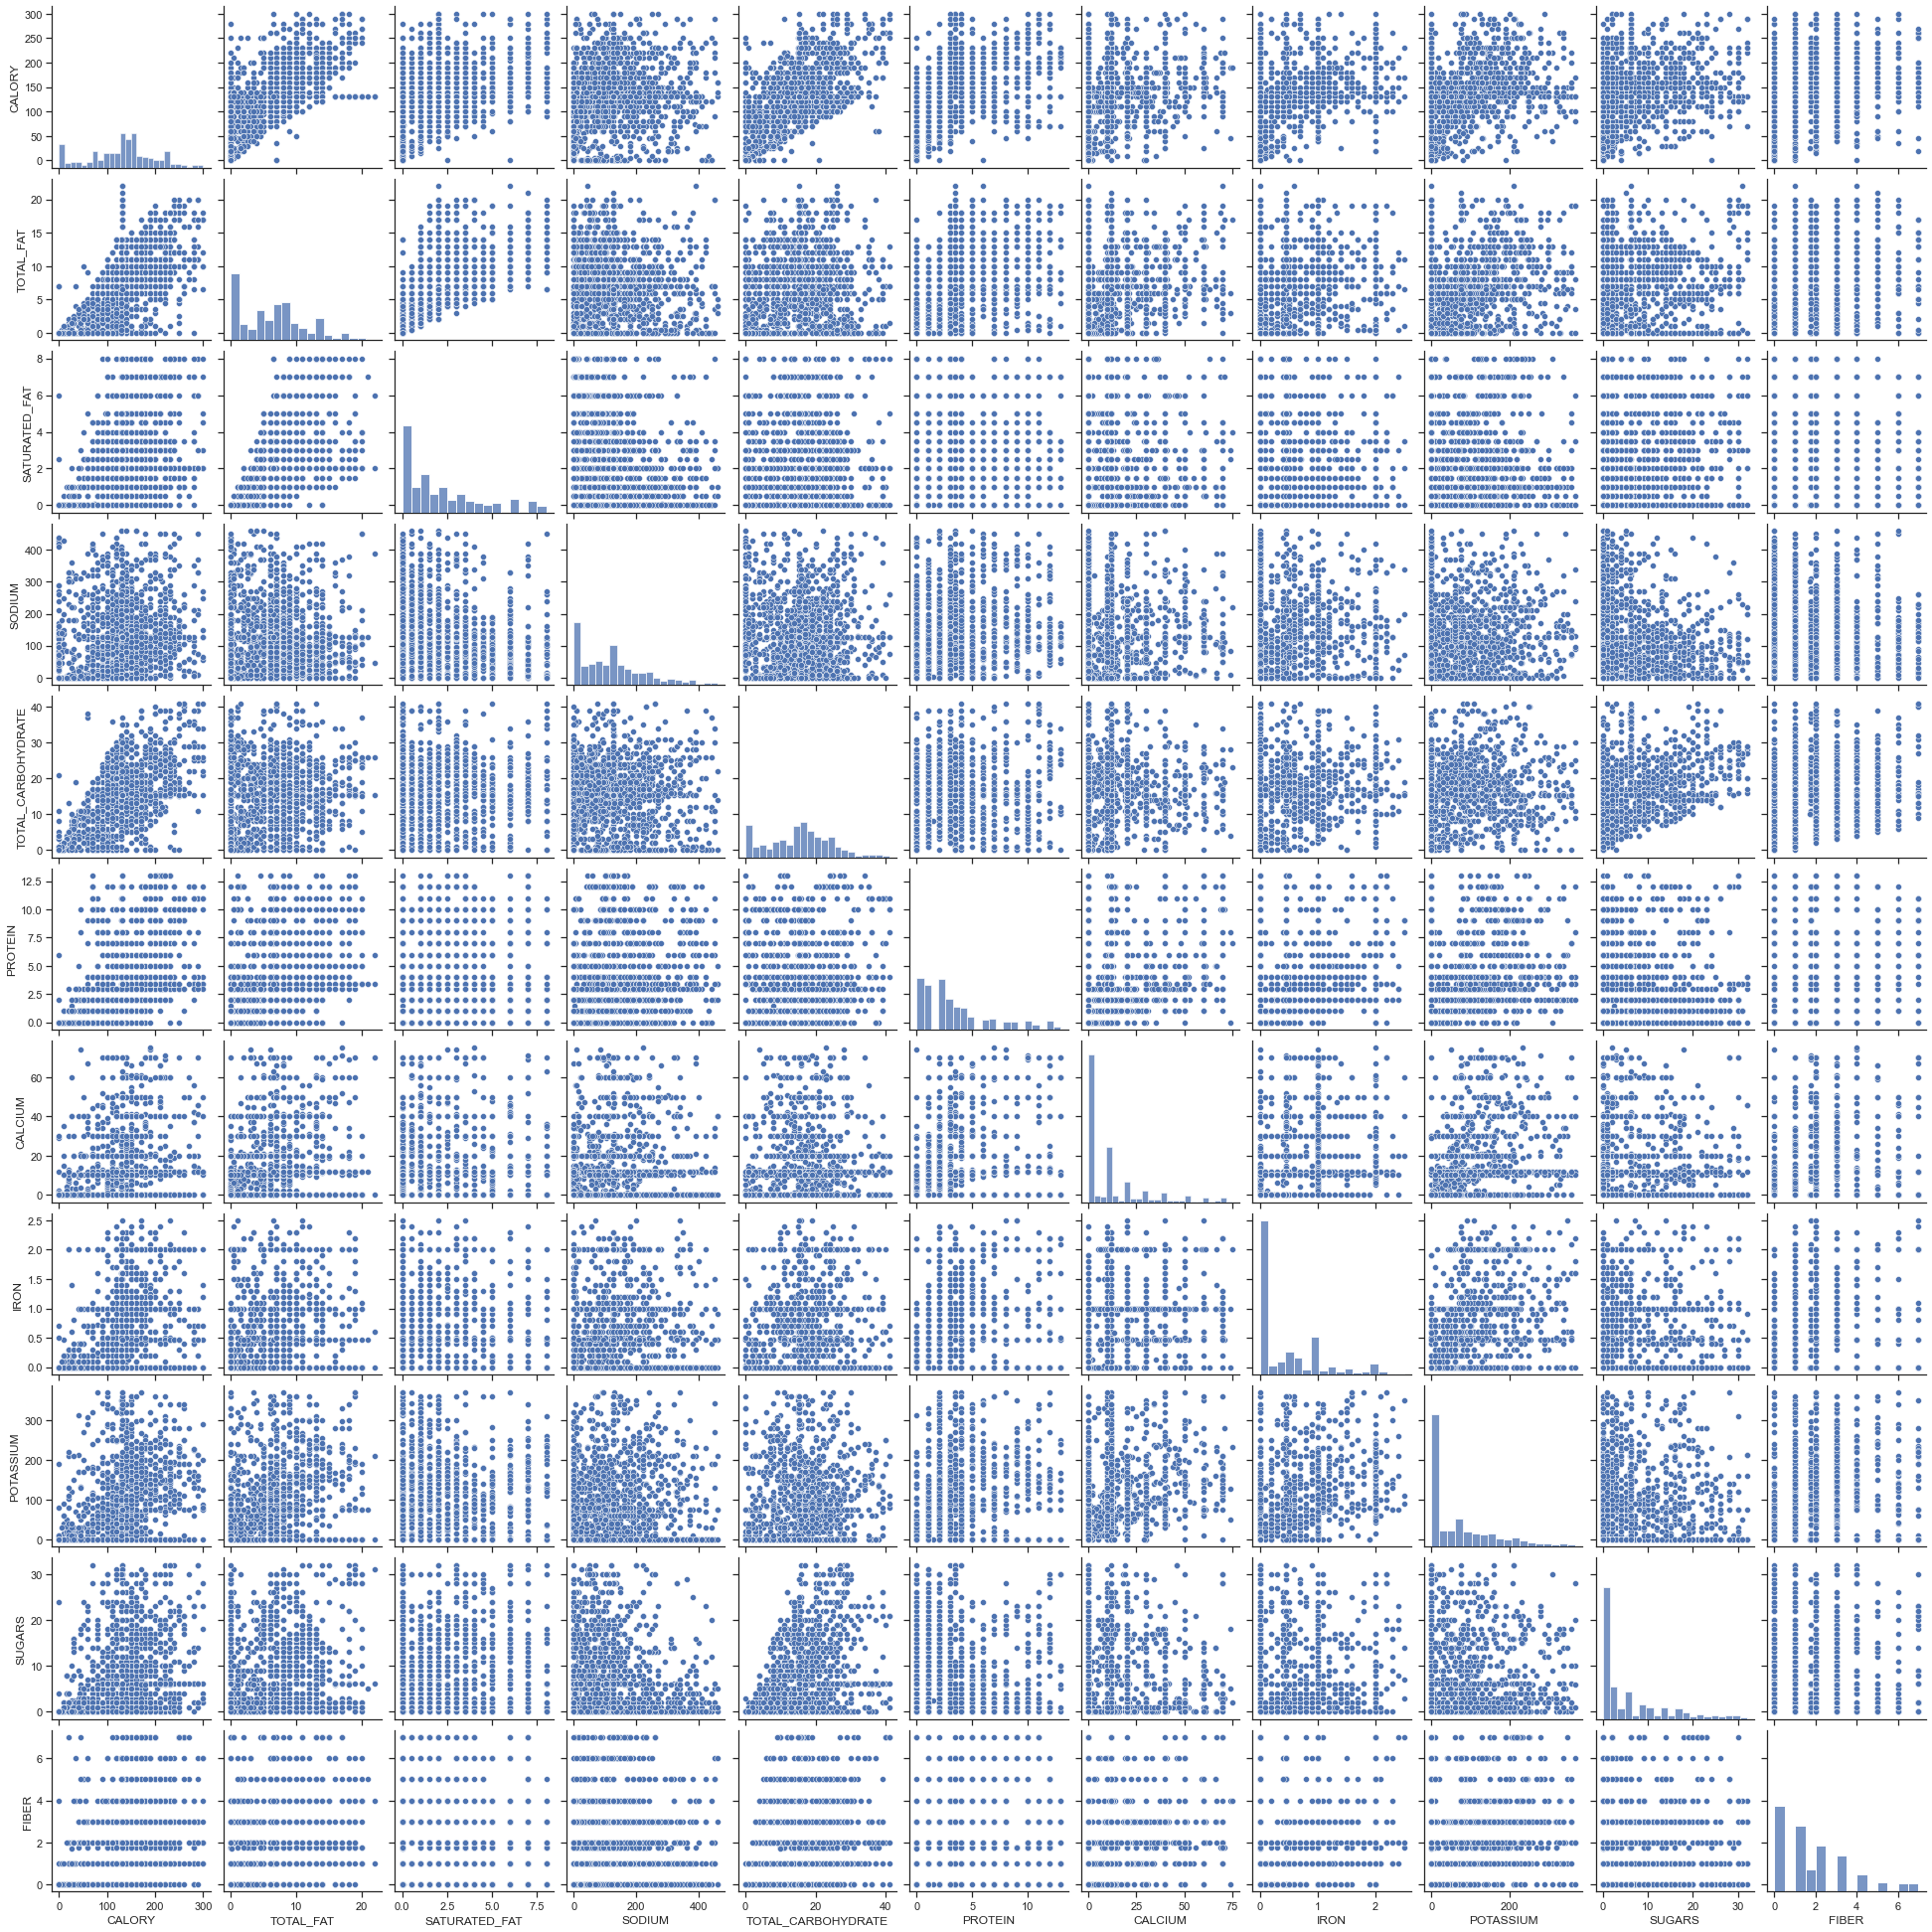

In [71]:
# pair plot of all the data to see the relations 
pair=sns.pairplot(all_df);
pair.savefig('pairPlot.png')

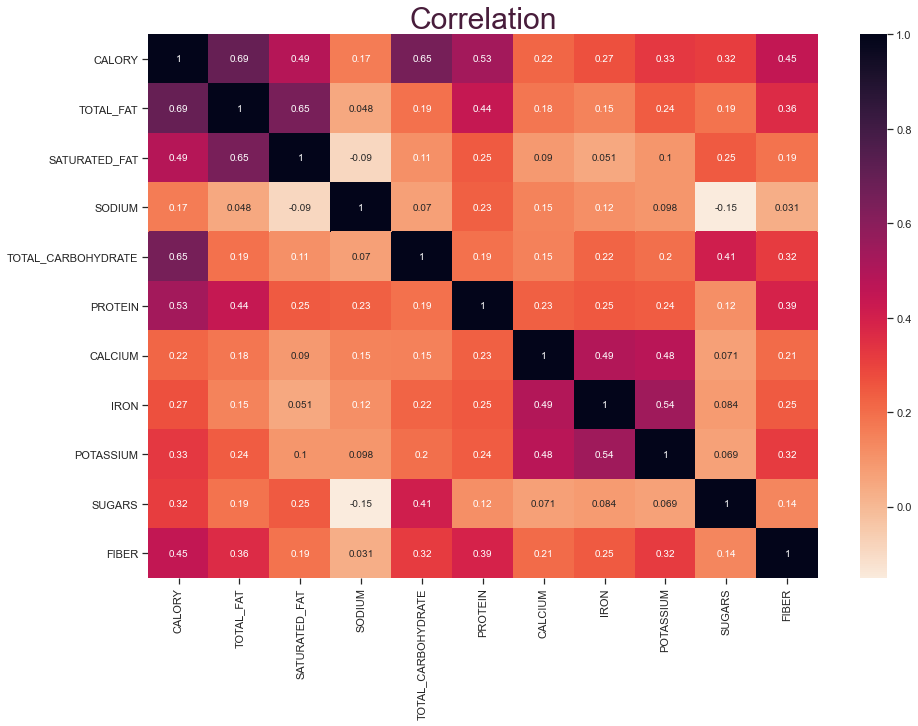

In [72]:
# plot the correlation in a heatmap
plt.figure(figsize = [15,10])
plt.title('Correlation', color= '#481D3B', fontsize=30)
sns.heatmap(corr, annot = True, cmap = sns.cm.rocket_r );
plt.savefig('heatmap.png')

### Split Features and Target 

In [73]:
# split the features and the target 
featurs = ['TOTAL_FAT','SATURATED_FAT',
           'SODIUM','TOTAL_CARBOHYDRATE',
           'PROTEIN','CALCIUM',
           'IRON','POTASSIUM',
           'SUGARS','FIBER']
target = all_df.CALORY

In [74]:
Xs = all_df[featurs]
y = target

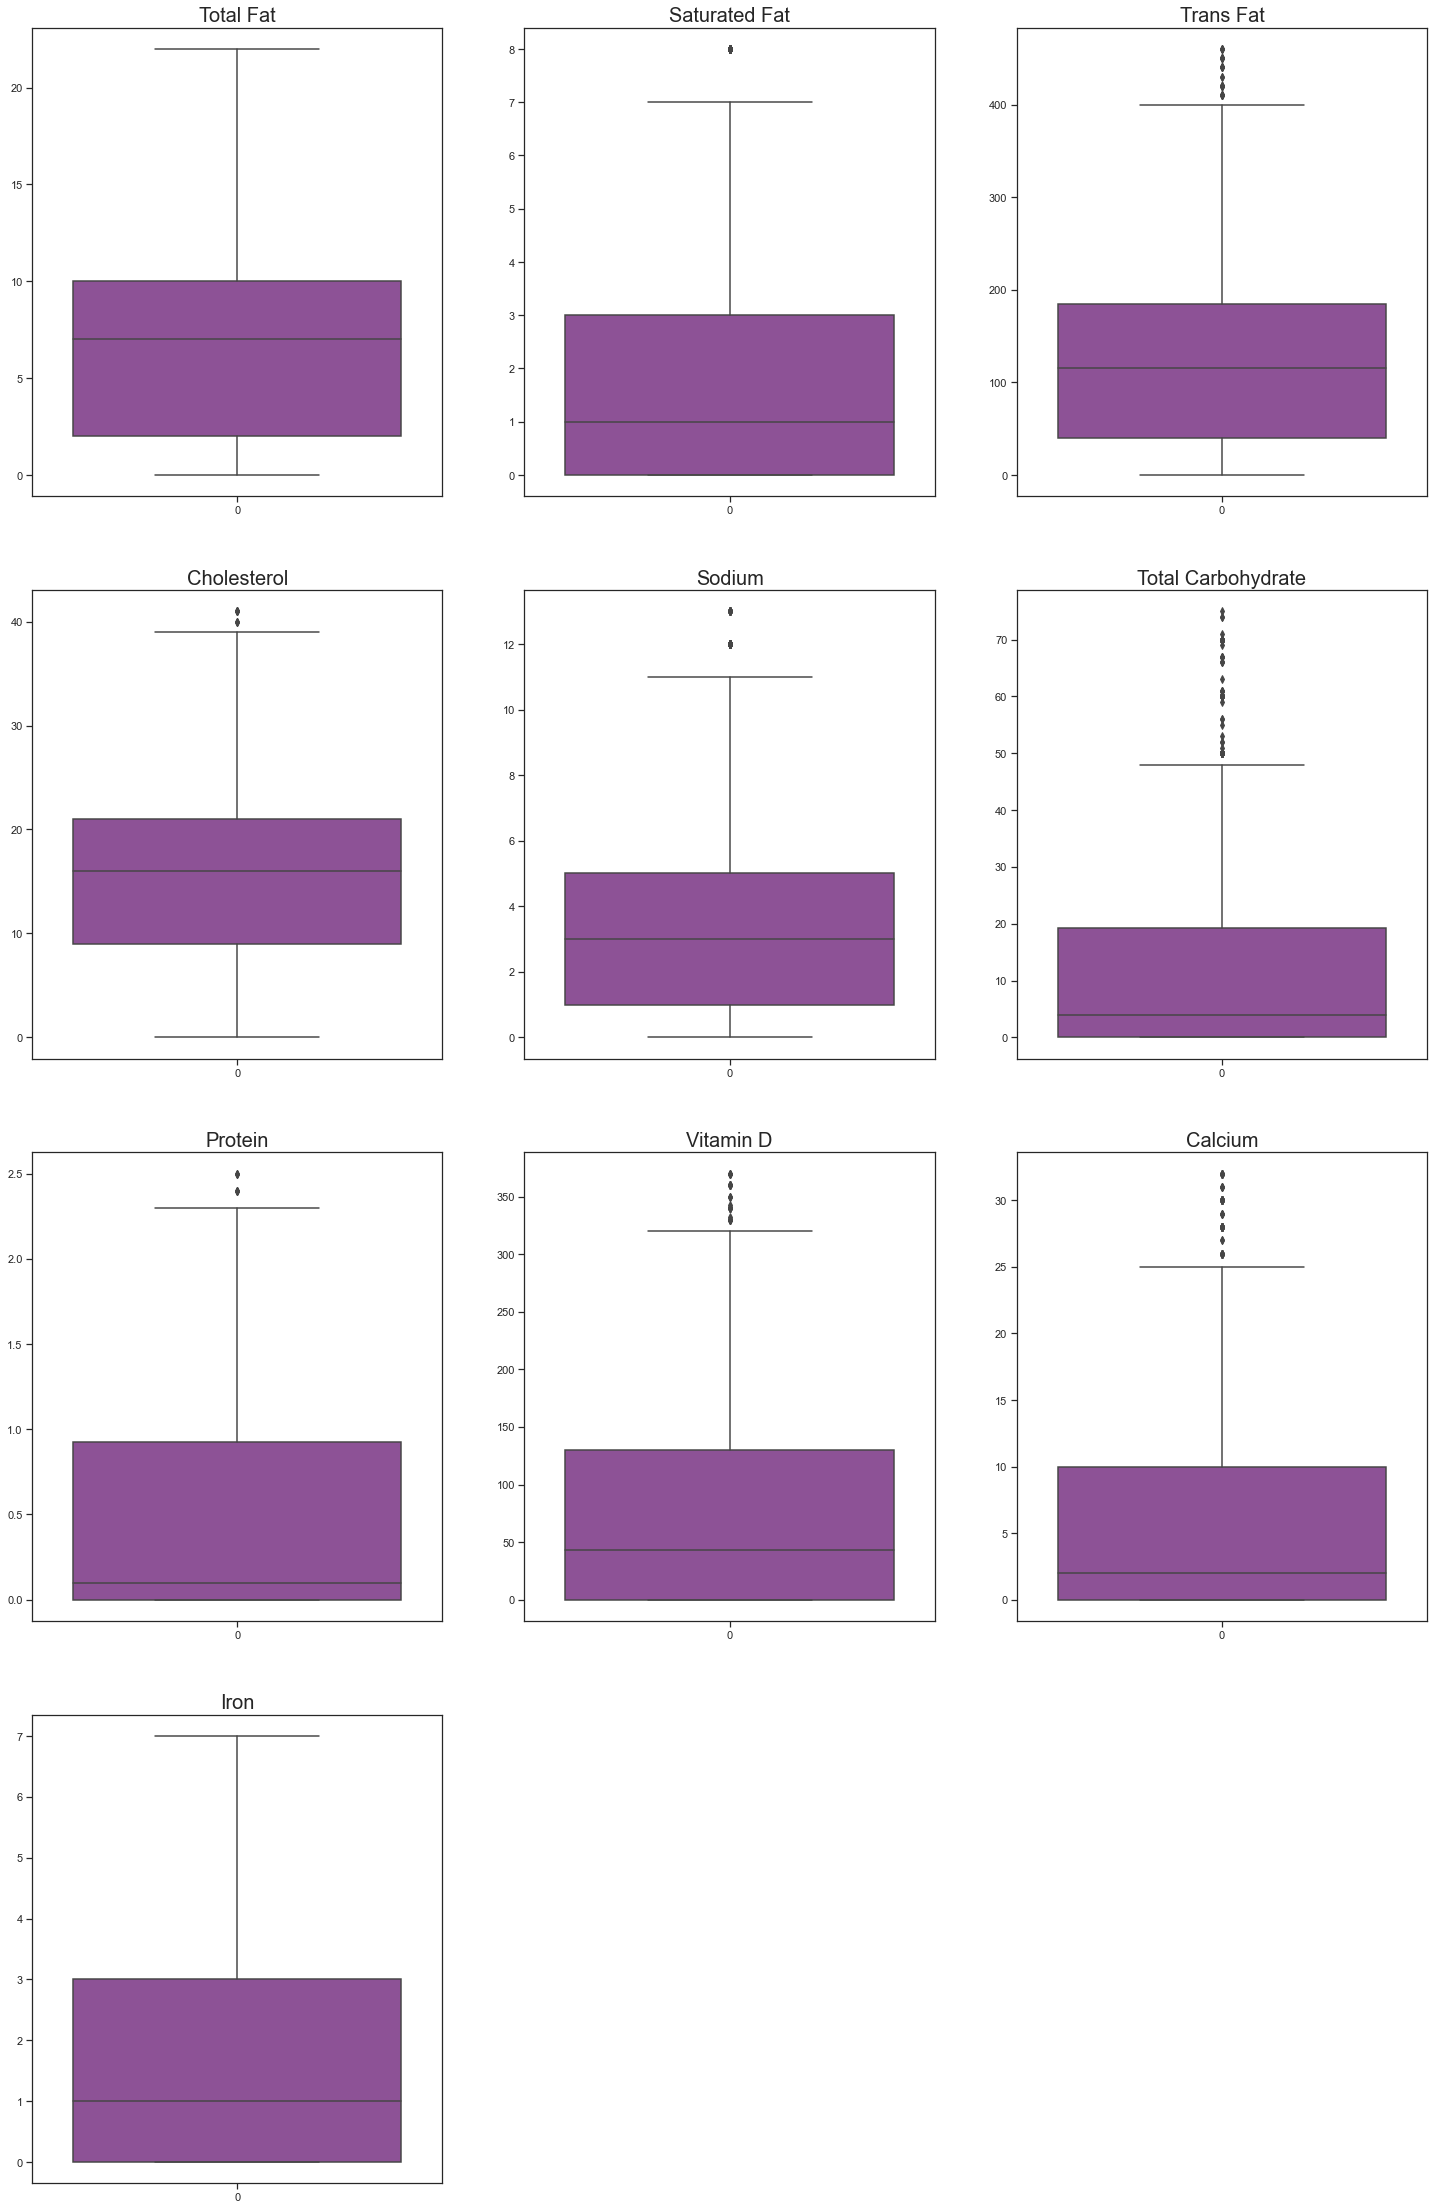

In [75]:
# First take a look to our data before log trasformation
plot_box(Xs, Xs.shape[1])

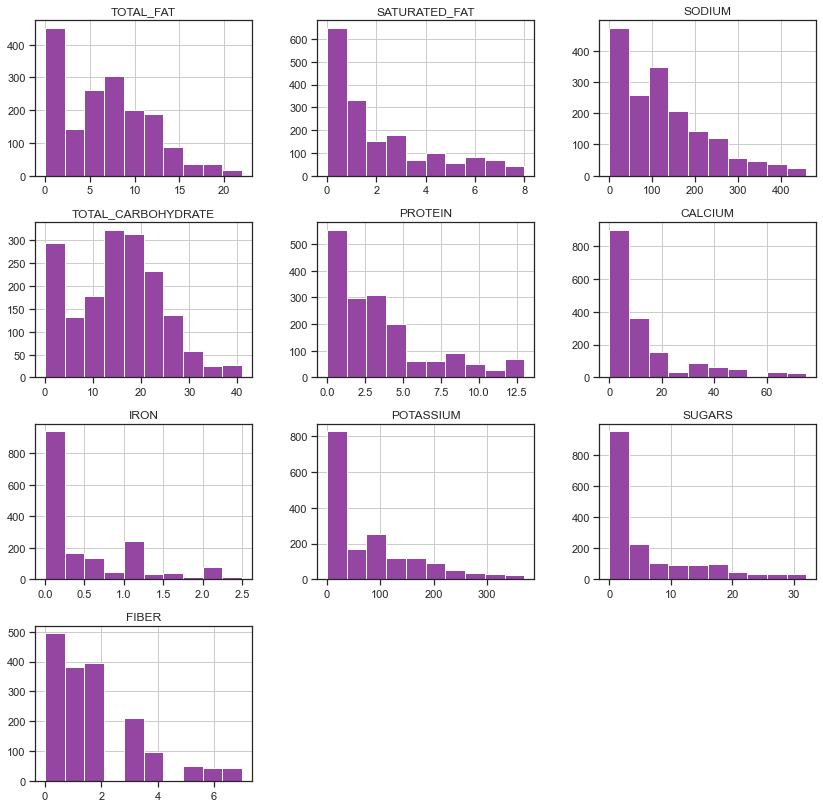

In [76]:
Xs.hist(figsize=(14, 14), color= '#9546A2');
plt.savefig('hist.png')

Now we will start Feature log transformation

### Log Transformation

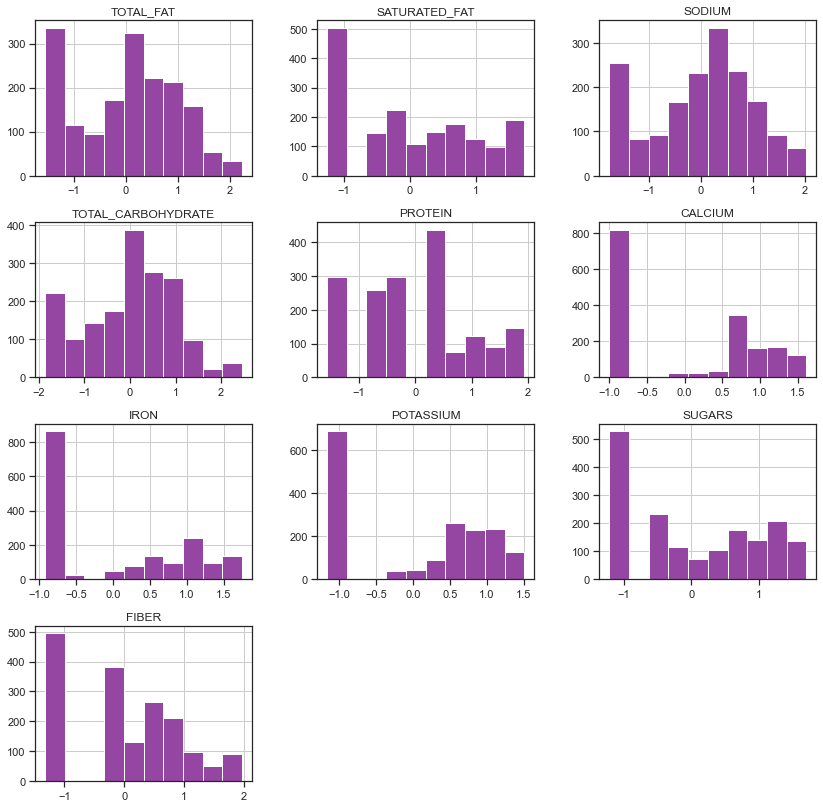

In [77]:
# Init
pt = PowerTransformer()
Xs = pd.DataFrame(pt.fit_transform(Xs), columns = Xs.columns)
Xs.hist(figsize=(14, 14), color= '#9546A2');
plt.savefig('hist_aft.png')

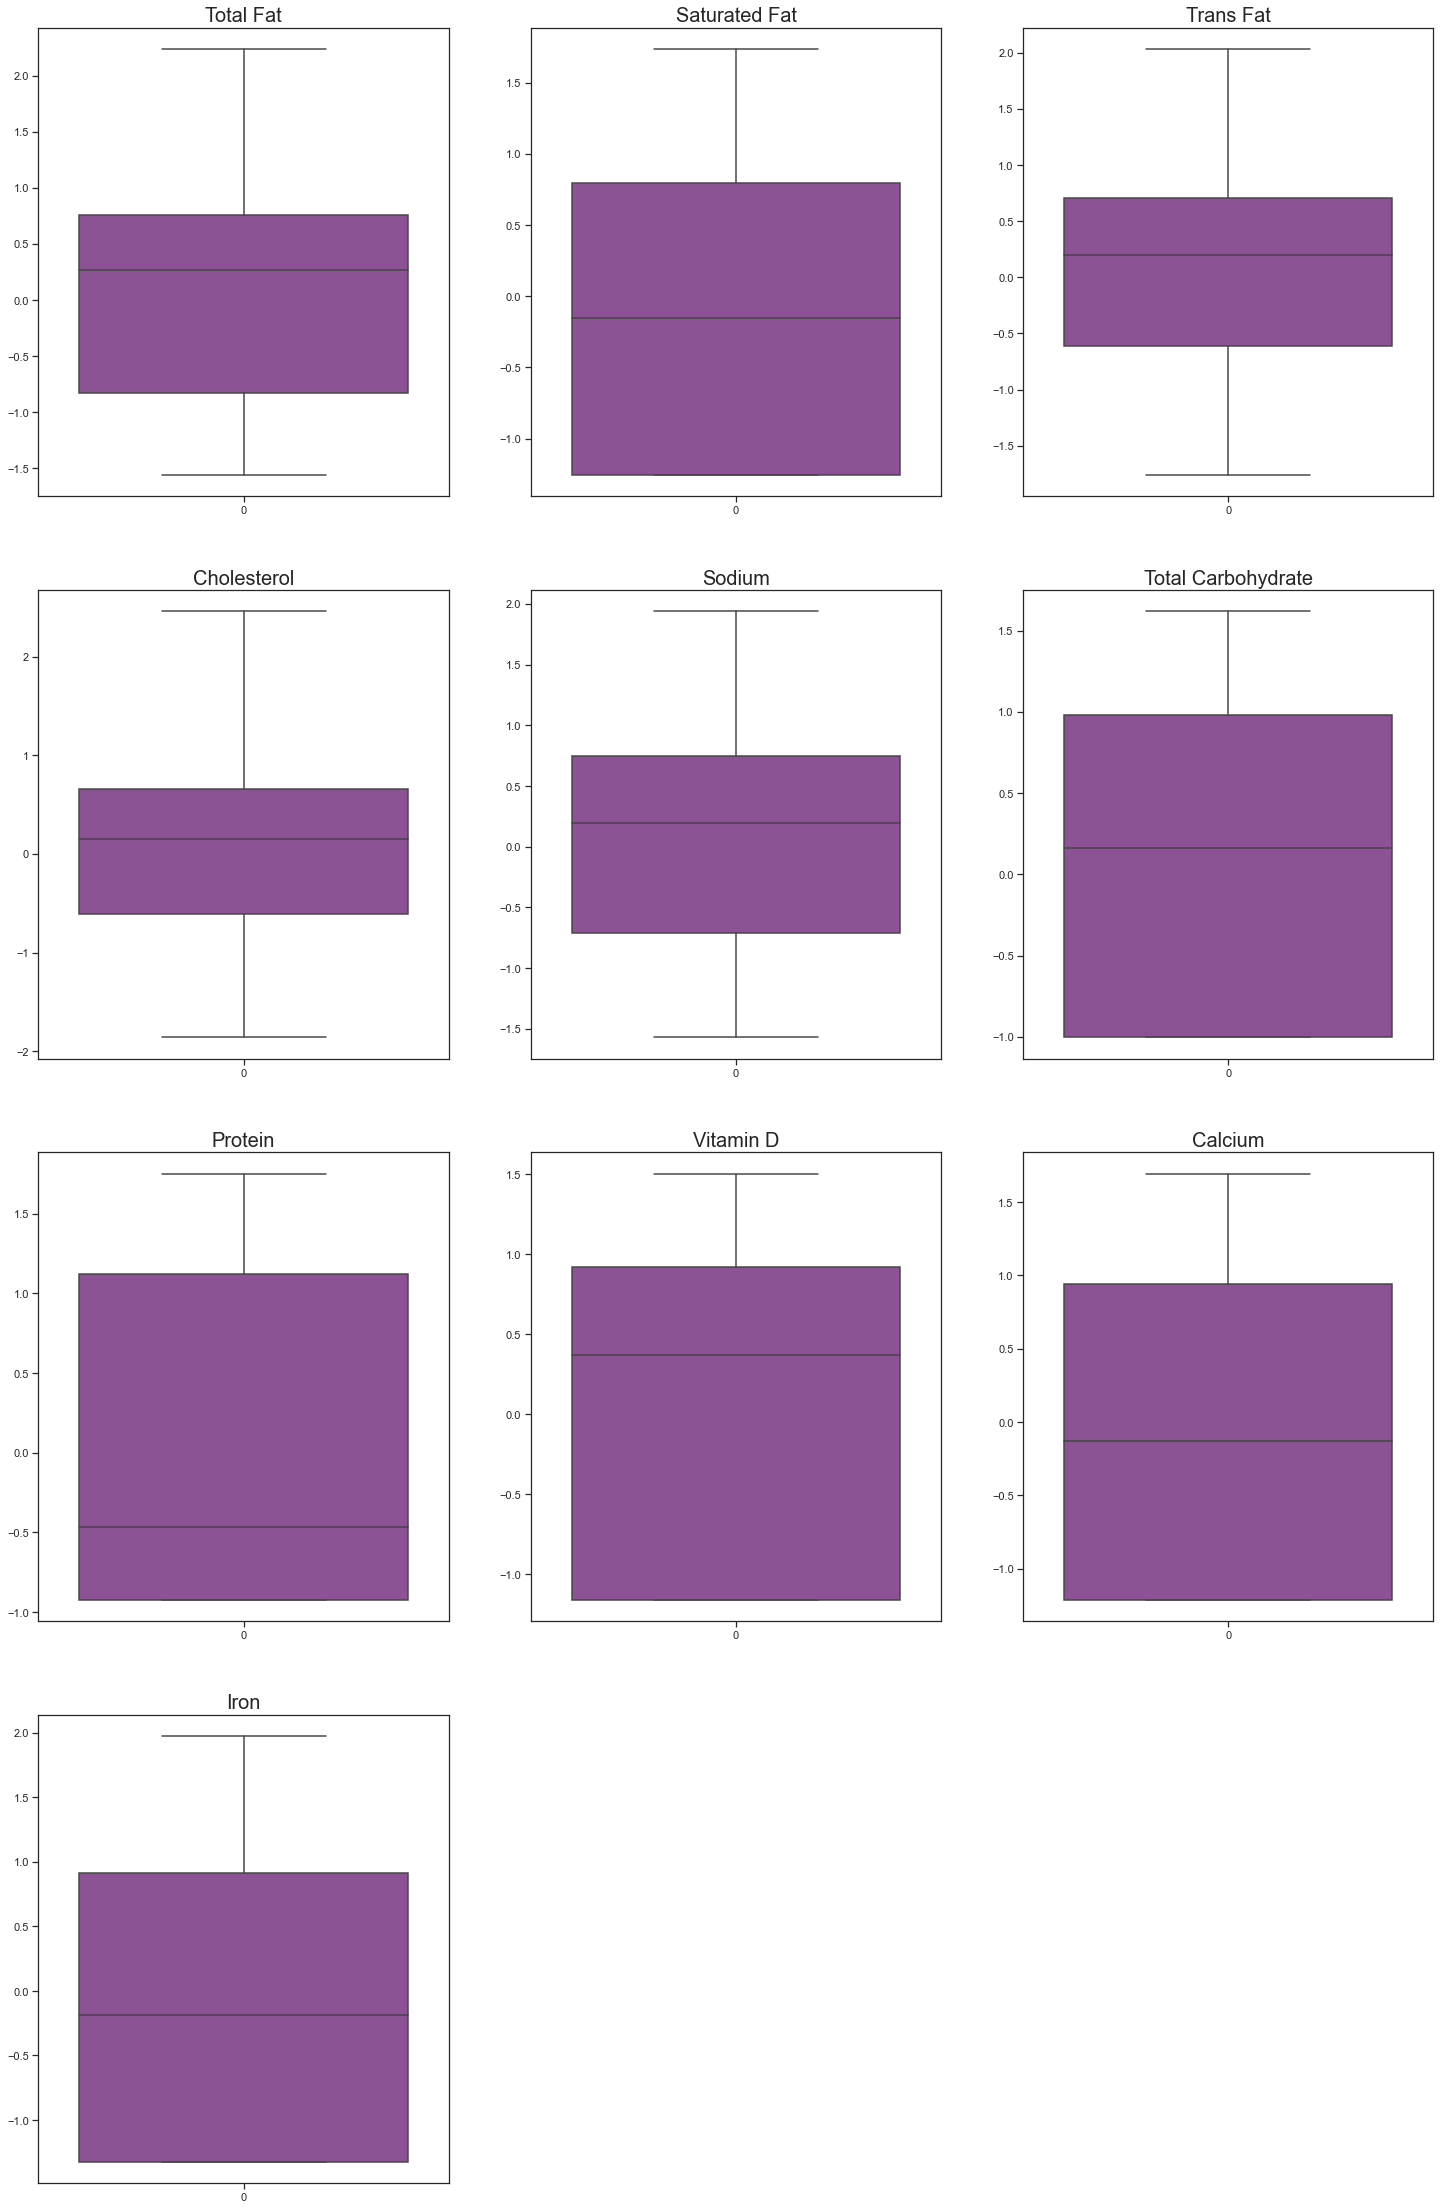

In [78]:
plot_box(Xs, Xs.shape[1]) ## result AFTER Log Transformation

As can be seen, the results changed better after transformation!

In [79]:
#split data (train - test)
Xs_val_train , Xs_test, y_val_train, y_test = train_test_split(Xs, y, test_size=.2, random_state=10) 

## Start Cross-Validation to Choose the Optimal Model 

In [80]:
# here we choose 6 models for our data
#we will do the CV for all models, and then we will choose the model with the best score to fit our data.
poly = make_pipeline(PolynomialFeatures(2), LinearRegression())

models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), poly, GradientBoostingRegressor()]
dic = {
    'LinearRegressionScore': [],
    'LassoScore': [],
    'RidgeScore': [],
    'ElasticNetScore': [],
    'polyDegree2Score': [], 
    'GradientBoostingRegressorScore': [],
}
keysList = list(dic.keys())
i = 0
for model in models:
    tmpList = cross_val_score(model, Xs_val_train, y_val_train, cv=5, scoring='r2')
    dic[keysList[i]].append(tmpList)
    i += 1
    
for key in keysList:
    dic[key] = np.mean(dic[key][0])

In [81]:
saveit(dic,'models_dic')

In [82]:
dic

{'LinearRegressionScore': 0.8281023848388853,
 'LassoScore': 0.8257135570421476,
 'RidgeScore': 0.8281154912845627,
 'ElasticNetScore': 0.7826761685081042,
 'polyDegree2Score': 0.8298150119923668,
 'GradientBoostingRegressorScore': 0.8898820845704861}

As can be seen, the Gradient Boosting Regressor Model generating the best score! We will try the polynomial with other degrees to look if it will gives better score.

In [83]:
# try polynimoal with degrees from 2 until 9 
poly_dic = {}
for degree in range(2,10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    tmpList = cross_val_score(est, Xs_val_train, y_val_train, cv=5, scoring='r2')
    poly_dic['PloyOfDegree' + str(degree)] = []
    poly_dic['PloyOfDegree' + str(degree)].append(tmpList)
    
for key in list(poly_dic.keys()):
    poly_dic[key] = np.mean(poly_dic[key][0])

In [84]:
saveit(poly_dic,'poly_dic')

In [85]:
poly_dic

{'PloyOfDegree2': 0.8298150119923668,
 'PloyOfDegree3': 0.7527317012468071,
 'PloyOfDegree4': -1926305.0359441482,
 'PloyOfDegree5': -6176886968859318.0,
 'PloyOfDegree6': -1.0621994531573082e+16,
 'PloyOfDegree7': -962867740083369.6,
 'PloyOfDegree8': -68349681721314.984,
 'PloyOfDegree9': -1.1025232350094758e+19}

The degree 2 produce the best result in polynimial, but still it's less than Gradient Boosting Regressor, so we will choose it for the next step Feature Engineering 

In [28]:
# save our sets to database
Xs_val_train_conn = sql.connect('Xs_val_train.db')
Xs_test_conn = sql.connect('Xs_test.db')
y_val_train_conn = sql.connect('y_val_train.db')
y_test_conn = sql.connect('y_test.db')

Xs_val_train.to_sql('Xs_val_train', Xs_val_train_conn)
Xs_test.to_sql('Xs_test', Xs_test_conn)
y_val_train.to_sql('y_val_train', y_val_train_conn)
y_test.to_sql('y_test', y_test_conn)